<h4>Thesis</h4>
<h6>These models try predict what is the final result of match, utilizing Gaussian Naive Bayes. <br>The variables X are: "home_team_cod", "away_team_cod", "half_time_home_team_goals", "half_time_away_team_goals", "B365H", "B365D", "B365A"<br>
The variables Y are: "full_time_result"</h6>

<h6>*The secret to increase the hit rate is to choose good variables. The better the variables the higher the hit rate will be.*</h6>

<h5>Import dataset</h5>
<h6>Font: https://www.football-data.co.uk/blog/index.php<h6>

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.min_rows', 200)
pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 100)

df_2021_2022 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
df_2022_2023 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")
df = pd.concat([df_2021_2022, df_2022_2023], axis=0)

df.rename(columns={"Date":"date", "Time":"time", "FTHG":"full_time_home_goals", "FTAG":"full_time_away_goals", "FTR":"full_time_result", 
                   "HomeTeam":"home_team", "AwayTeam":"away_team", "HTHG":"half_time_home_team_goals", 
                   "HTAG":"half_time_away_team_goals", "HTR":"half_time_result", "HS":"home_team_shots", "AS":"away_team_shots", 
                   "HST":"home_team_shots_on_target", "AST":"away_team_shots_on_target"}, inplace=True)
df = df.astype({"date":"datetime64"})
df = df.convert_dtypes(infer_objects=True)
df = df[["date", "home_team", "away_team", "half_time_home_team_goals", "half_time_away_team_goals", "full_time_result", "B365H", "B365D", "B365A"]]

df.tail()

,date,home_team,away_team,half_time_home_team_goals,half_time_away_team_goals,full_time_result,B365H,B365D,B365A
205,2023-04-02,Wolves,Liverpool,2,0,H,4.00,3.8,1.85
206,2023-04-02,Newcastle,West Ham,1,1,D,1.60,3.8,6.00
207,2023-05-02,Nott'm Forest,Leeds,1,0,H,2.63,3.3,2.70
208,2023-05-02,Tottenham,Man City,1,0,H,4.33,4.2,1.73
209,2023-08-02,Man United,Leeds,0,1,D,1.45,5.0,6.00


<h5>Exploratory data analysis (EDA)</h5>

(590, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 590 entries, 0 to 209
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       590 non-null    datetime64[ns]
 1   home_team                  590 non-null    string        
 2   away_team                  590 non-null    string        
 3   half_time_home_team_goals  590 non-null    Int64         
 4   half_time_away_team_goals  590 non-null    Int64         
 5   full_time_result           590 non-null    string        
 6   B365H                      590 non-null    float64       
 7   B365D                      590 non-null    float64       
 8   B365A                      590 non-null    float64       
dtypes: Int64(2), datetime64[ns](1), float64(3), string(3)
memory usage: 47.2 KB
None


<AxesSubplot:>

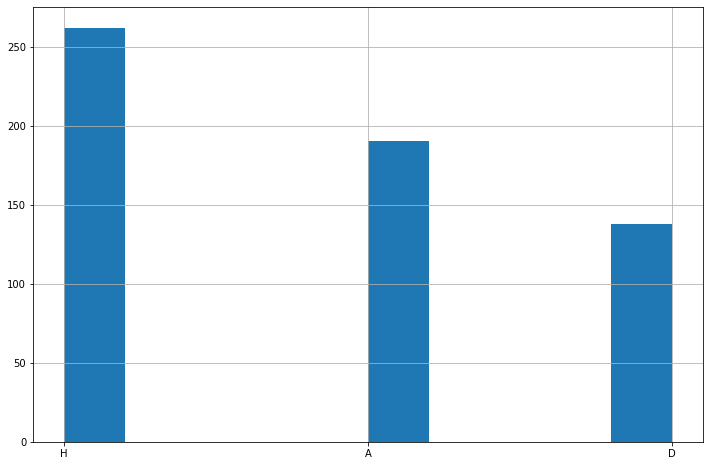

In [21]:
print(df.shape)
print(df.info())
df["full_time_result"].hist(figsize=(12,8))

<h5>Correlation</h5>

<AxesSubplot:>

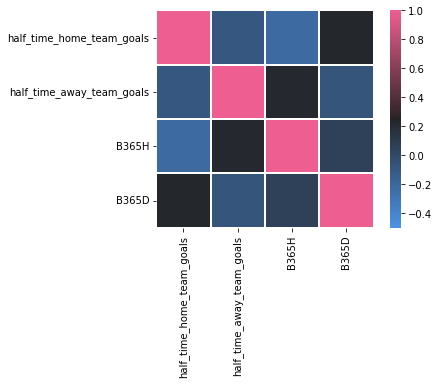

In [22]:
correlation = df.iloc[:, :-1].corr(method="pearson")
cmap = sns.diverging_palette(250, 354, 80, 60, center="dark", as_cmap=True)
sns.heatmap(correlation, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

<h5>Distribution</h5>

<AxesSubplot:xlabel='half_time_away_team_goals', ylabel='Count'>

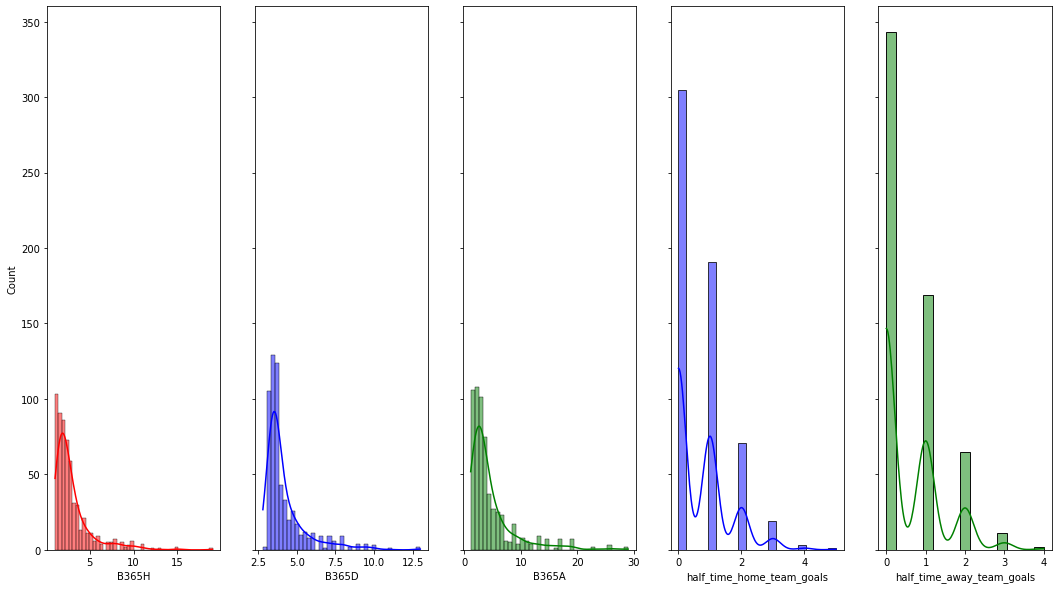

In [23]:
df_distribution = df[["home_team", "away_team", "half_time_home_team_goals", "half_time_away_team_goals", "full_time_result", "B365H", "B365D", "B365A"]]
df_distribution = df_distribution.astype({"half_time_home_team_goals":"float", "half_time_away_team_goals":"float"})
df_distribution.reset_index(drop=True, inplace=True)

fig, axes = plt.subplots(1, 5, figsize=(18, 10), sharey=True)
sns.histplot(df_distribution, ax=axes[0], x="B365H", kde=True, color="r")
sns.histplot(df_distribution, ax=axes[1], x="B365D", kde=True, color="b")
sns.histplot(df_distribution, ax=axes[2], x="B365A", kde=True, color="g")
sns.histplot(df_distribution, ax=axes[3], x="half_time_home_team_goals", kde=True, color="b")
sns.histplot(df_distribution, ax=axes[4], x="half_time_away_team_goals", kde=True, color="g")

<h5>Feature Engeenering</h5>

In [24]:
labelencoder = LabelEncoder()
df["full_time_result_cod"] = labelencoder.fit_transform(df["full_time_result"])
df["home_team_cod"] = labelencoder.fit_transform(df["home_team"]) 
df["away_team_cod"] = labelencoder.fit_transform(df["away_team"]) 
df.tail()
# 0=A / 1=D / 2=H

,date,home_team,away_team,half_time_home_team_goals,half_time_away_team_goals,full_time_result,B365H,B365D,B365A,full_time_result_cod,home_team_cod,away_team_cod
205,2023-04-02,Wolves,Liverpool,2,0,H,4.00,3.8,1.85,2,22,12
206,2023-04-02,Newcastle,West Ham,1,1,D,1.60,3.8,6.00,1,15,21
207,2023-05-02,Nott'm Forest,Leeds,1,0,H,2.63,3.3,2.70,2,17,10
208,2023-05-02,Tottenham,Man City,1,0,H,4.33,4.2,1.73,2,19,13
209,2023-08-02,Man United,Leeds,0,1,D,1.45,5.0,6.00,1,14,10


<h5>Split Train and Test</h5>

In [25]:
X = df[["home_team_cod", "away_team_cod", "half_time_home_team_goals", "half_time_away_team_goals", "B365H", "B365D", "B365A"]]
y = df["full_time_result"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(413, 7) (177, 7) (413,) (177,)


<h5>Train the Model</h5>

In [26]:
model = GaussianNB(priors=None, var_smoothing=1e-09)
model.fit(X_train, y_train)

GaussianNB()

<h5>Evaluate the Model</h5>

In [27]:
y_predictions = model.predict(X_test)

print(f"Accuracy score (training): {model.score(X_train, y_train)}")
print(f"Accuracy score (validation): {model.score(X_test, y_test)}\n")
print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_predictions)}\n")
print(f"Classification Report:\n {classification_report(y_test, y_predictions)}")

Accuracy score (training): 0.6101694915254238
Accuracy score (validation): 0.615819209039548

Confusion Matrix:
 [[43  7  3]
 [11 25  8]
 [ 9 30 41]]

Classification Report:
               precision    recall  f1-score   support

           A       0.68      0.81      0.74        53
           D       0.40      0.57      0.47        44
           H       0.79      0.51      0.62        80

    accuracy                           0.62       177
   macro avg       0.62      0.63      0.61       177
weighted avg       0.66      0.62      0.62       177



<h5>Probabilities of classification</h5>

In [29]:
knn = GaussianNB(priors=None, var_smoothing=1e-09)
knn.fit(X, y)

predict_probability = knn.predict_proba(X)
df["probability_A"] = predict_probability[:, 0].round(2) * 100
df["probability_D"] = predict_probability[:, 1].round(2) * 100
df["probability_H"] = predict_probability[:, 2].round(2) * 100
df

,date,home_team,away_team,half_time_home_team_goals,half_time_away_team_goals,full_time_result,B365H,B365D,B365A,full_time_result_cod,home_team_cod,away_team_cod,probability_A,probability_D,probability_H
0,2021-08-13,Brentford,Arsenal,1,0,H,4.00,3.40,1.95,2,3,0,25.0,53.0,22.0
1,2021-08-14,Man United,Leeds,1,0,H,1.53,4.50,5.75,2,14,10,5.0,37.0,58.0
2,2021-08-14,Burnley,Brighton,1,0,A,3.10,3.10,2.45,0,5,4,15.0,50.0,35.0
3,2021-08-14,Chelsea,Crystal Palace,2,0,H,1.25,5.75,13.00,2,6,7,0.0,0.0,100.0
4,2021-08-14,Everton,Southampton,0,1,H,1.90,3.50,4.00,2,8,18,44.0,45.0,12.0
5,2021-08-14,Leicester,Wolves,1,0,H,1.66,3.80,5.25,2,11,22,6.0,36.0,58.0
6,2021-08-14,Watford,Aston Villa,2,0,H,3.10,3.20,2.37,2,20,1,1.0,12.0,86.0
7,2021-08-14,Norwich,Liverpool,0,1,A,9.00,5.75,1.30,0,16,12,99.0,1.0,0.0
8,2021-08-15,Newcastle,West Ham,2,1,A,3.20,3.50,2.20,0,15,21,3.0,25.0,72.0
9,2021-08-15,Tottenham,Man City,0,0,H,5.50,4.20,1.60,2,19,13,71.0,27.0,1.0
